In [15]:
import numpy as np
import scipy.io as sio
import glob
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import welch

#from tensorflow.keras import layers
#from tensorflow.keras import Sequential, Model

In [16]:
# find all ecg-files
home_dir = '/home/roland/Schreibtisch/nonlinear/Training_WFDB/'
mat_files = np.array(glob.glob(home_dir + '*.mat'))
hea_files = np.array(glob.glob(home_dir + '*.hea'))

In [17]:
# synchronize files, mat-file belongs to corresponding hea-file
m = np.argsort(mat_files)
h = np.argsort(hea_files)
mat_files = mat_files[m]
hea_files = hea_files[h]

In [18]:
# load ecg and save it into numpy-array
ecg = []
for mat_file in mat_files:
    ecg.append(sio.loadmat(mat_file)['val'].T)
ecg = np.asarray(ecg)

In [19]:
# get labels of ecgs
labels = []
#hertz = []
for hea_file in hea_files:
    data = pd.read_csv(hea_file, sep='\t', header=None).values
    label = data[15,0][5:].split(',' ,1)[0]
    h = int(data[0,0][9:12])
    #hertz.append(h)
    labels.append(label)

# translate illness-description into numbers
d = {'AF':0, 'I-AVB':1, 'LBBB':2, 'Normal':3, 'PAC':4, 'PVC':5, 'RBBB':6, 'STD':7, 'STE':8}
y = np.array([d[label] for label in labels])

In [20]:
ffts = []
for ecg_ in ecg:
    fft = np.fft.rfft(ecg_, axis=0)
    fft = np.abs(fft)
    ffts.append(fft)
    
n = len(ffts[0])
timestep = 1/500
freq = np.fft.fftfreq(n, d=timestep)
#ecg[0].shape

In [ ]:
np.save('ecg.npy', ecg)

In [21]:
#l = []
#for e in ecg:
#    l.append(len(e))
#np.where(l==np.min(l)), np.where(l==np.max(l))

In [22]:
#ffts[5276].shape, freq.shape

In [7]:
#f = ffts[5276]
#plt.plot(np.fft.fftfreq(len(f), d=timestep)*60, f[:,10])

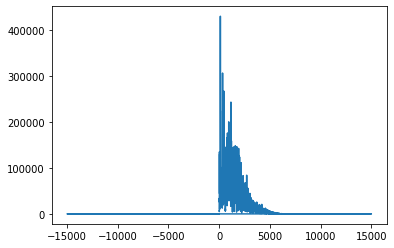

In [12]:
# plot example-fft on random ecg on random channel
f = ffts[1000]

fr = np.fft.fftfreq(len(f), d=timestep)*60 #frequency in [1/min]
plt.plot(fr, f[:,10])

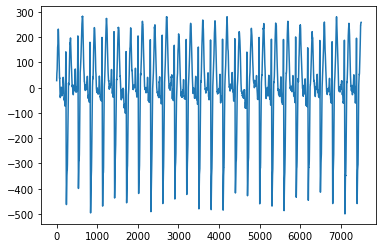

In [13]:
# plot example ecg
plt.plot(ecg[0][:,0])

In [14]:
#fs = 500

#i = 1000
#f, Pxx = welch(ecg[i][:,0], fs=fs, nperseg=2048, scaling="spectrum")
#plt.semilogy(f, Pxx, label=labels[i])
#plt.xlabel("Frequency in Hz")
#plt.ylabel("Power spectrum of the ECG in mV**2")
#plt.xlim(f[[0, -1]])
#plt.legend()
#plt.show()

In [22]:
leads = 12
latent_dim = 64

lstm_input = layers.Input(shape=(None, leads))
lstm_output = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(lstm_input)
#lstm_output = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(lstm_output)
#lstm_output = layers.GlobalAveragePooling1D()(lstm_output)

lstm_output = layers.Dense(256)(lstm_output)
lstm_output = layers.Dense(1)(lstm_output)

model = Model(lstm_input, lstm_output)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 12)]        0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               39424     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 72,705
Trainable params: 72,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def train_generator():
    i=-1
    while i<len(ecg):
        i+=1
        yield np.reshape(ecg[i], (1, ecg[i].shape[0], ecg[i].shape[1])), y[i]

model.fit_generator(train_generator(), steps_per_epoch=30, epochs=32, verbose=1)

  ...
    to  
  ['...']
Train for 30 steps
Epoch 1/32
30/30 [==============================] - 27s 895ms/step - loss: 4.3710e-07
Epoch 2/32
30/30 [==============================] - 24s 794ms/step - loss: 6.0002e-07
Epoch 3/32
30/30 [==============================] - 23s 768ms/step - loss: 4.6094e-07
Epoch 4/32
30/30 [==============================] - 23s 769ms/step - loss: 5.2055e-07
Epoch 5/32
28/30 [===========================>..] - ETA: 1s - loss: 5.0664e-07

In [21]:
n = 1000
model.predict(np.reshape(ecg[n], (1,ecg[n].shape[0], ecg[n].shape[1])))

array([[ 6.47795677e-01, -6.49193525e-01,  2.90299594e-01,
        -4.47146893e-01,  1.60226658e-01, -1.92952916e-01,
        -4.49718386e-01, -5.01525760e-01,  2.09519379e-02,
         8.06282520e-01,  4.81536128e-02,  8.42412636e-02,
        -1.36849076e-01, -8.19083750e-01, -2.73344904e-01,
        -6.10009097e-02,  5.52647896e-02,  5.37782848e-01,
        -3.03214252e-01, -4.69544947e-01,  3.85283828e-02,
         1.14339516e-01,  7.14485571e-02,  3.19652140e-01,
         2.31657289e-02, -3.49009633e-02,  8.14118981e-02,
        -1.03072822e-01,  1.43458173e-02, -5.48977375e-01,
        -5.15433788e-01,  4.22444344e-01, -7.77337790e-01,
        -8.13463628e-01, -7.34924436e-01, -5.91454983e-01,
         2.29075521e-01,  9.84246552e-01,  6.61947787e-01,
        -3.20728183e-01,  4.63013887e-01, -4.34761345e-01,
         8.58547509e-01, -4.25053835e-02,  5.98003745e-01,
        -8.03113580e-02,  2.39488304e-01,  9.89859104e-02,
         2.70611048e-01, -1.25401080e-01,  3.38361055e-0

In [89]:
kranks = {'AX':1, 'CBB':2}
kranks['CBB']

2

In [35]:
model = Sequential([
    
    #LSTM
    layers.LSTM(32, return_sequences=True, input_shape=(None, 12)),
    layers.TimeDistributed(layers.Dense(2, activation='sigmoid')),
    layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam')

In [50]:
#model.summary()
model.fit(ecg, y_train)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [22]:
mat_contents['val'].shape

(12, 18488)

<IPython.core.display.Javascript object>


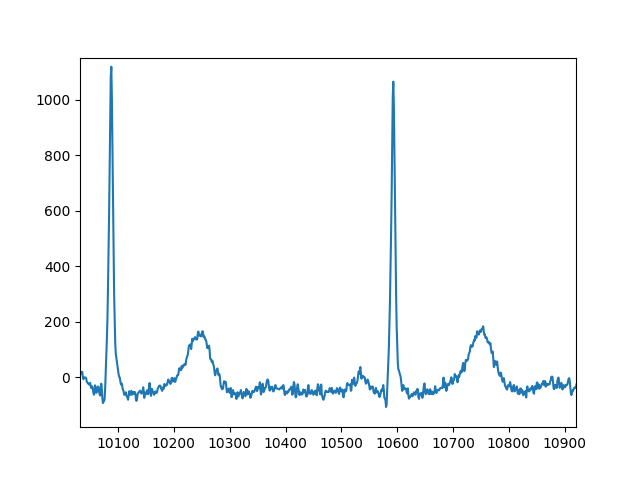

In [25]:
%matplotlib notebook
plt.plot(mat_contents['val'][0,:])